In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
!pip install yfinance
import yfinance as yf

In [ ]:
df= yf.Ticker("^NSEBANK").history(period='3y').reset_index()
df_axis= yf.Ticker("AXISBANK.NS").history(period='3y').reset_index()
df_sbi= yf.Ticker("SBIN.NS").history(period='3y').reset_index()
df_rbl= yf.Ticker("RBLBANK.NS").history(period='3y').reset_index()
df_pnb= yf.Ticker("PNB.NS").history(period='3y').reset_index()
df_kot= yf.Ticker("KOTAKBANK.NS").history(period='3y').reset_index()
df_ind= yf.Ticker("INDUSINDBK.NS").history(period='3y').reset_index()
df_idfc= yf.Ticker("IDFCFIRSTB.NS").history(period='3y').reset_index()
df_icic= yf.Ticker("ICICIBANK.NS").history(period='3y').reset_index()
df_band= yf.Ticker("BANDHANBNK.NS").history(period='3y').reset_index()
df_hdfc= yf.Ticker("HDFC.NS").history(period='3y').reset_index()
df_fed= yf.Ticker("FEDERALBNK.NS").history(period='3y').reset_index()
df_au= yf.Ticker("AUBANK.NS").history(period='3y').reset_index()

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-03-15 00:00:00+05:30,35543.835627,35543.835627,34430.247047,35182.140625,0,0.0,0.0
1,2021-03-16 00:00:00+05:30,35351.587361,35404.637523,34744.196013,34804.195312,0,0.0,0.0
2,2021-03-17 00:00:00+05:30,34904.644477,35100.091421,34126.454317,34228.851562,0,0.0,0.0
3,2021-03-18 00:00:00+05:30,34577.097070,34759.446508,33597.159271,33856.406250,0,0.0,0.0
4,2021-03-19 00:00:00+05:30,33590.006662,34354.997740,33360.610900,34161.203125,0,0.0,0.0


In [ ]:
import plotly.express as px
fig = px.line(df, x='Date', y="Open")
fig.show()

In [ ]:
print(df_rbl.Date.max())
print(df_rbl.Date.min())

2024-03-13 00:00:00+05:30
2021-03-15 00:00:00+05:30


Text(0.5, 1.0, 'au')

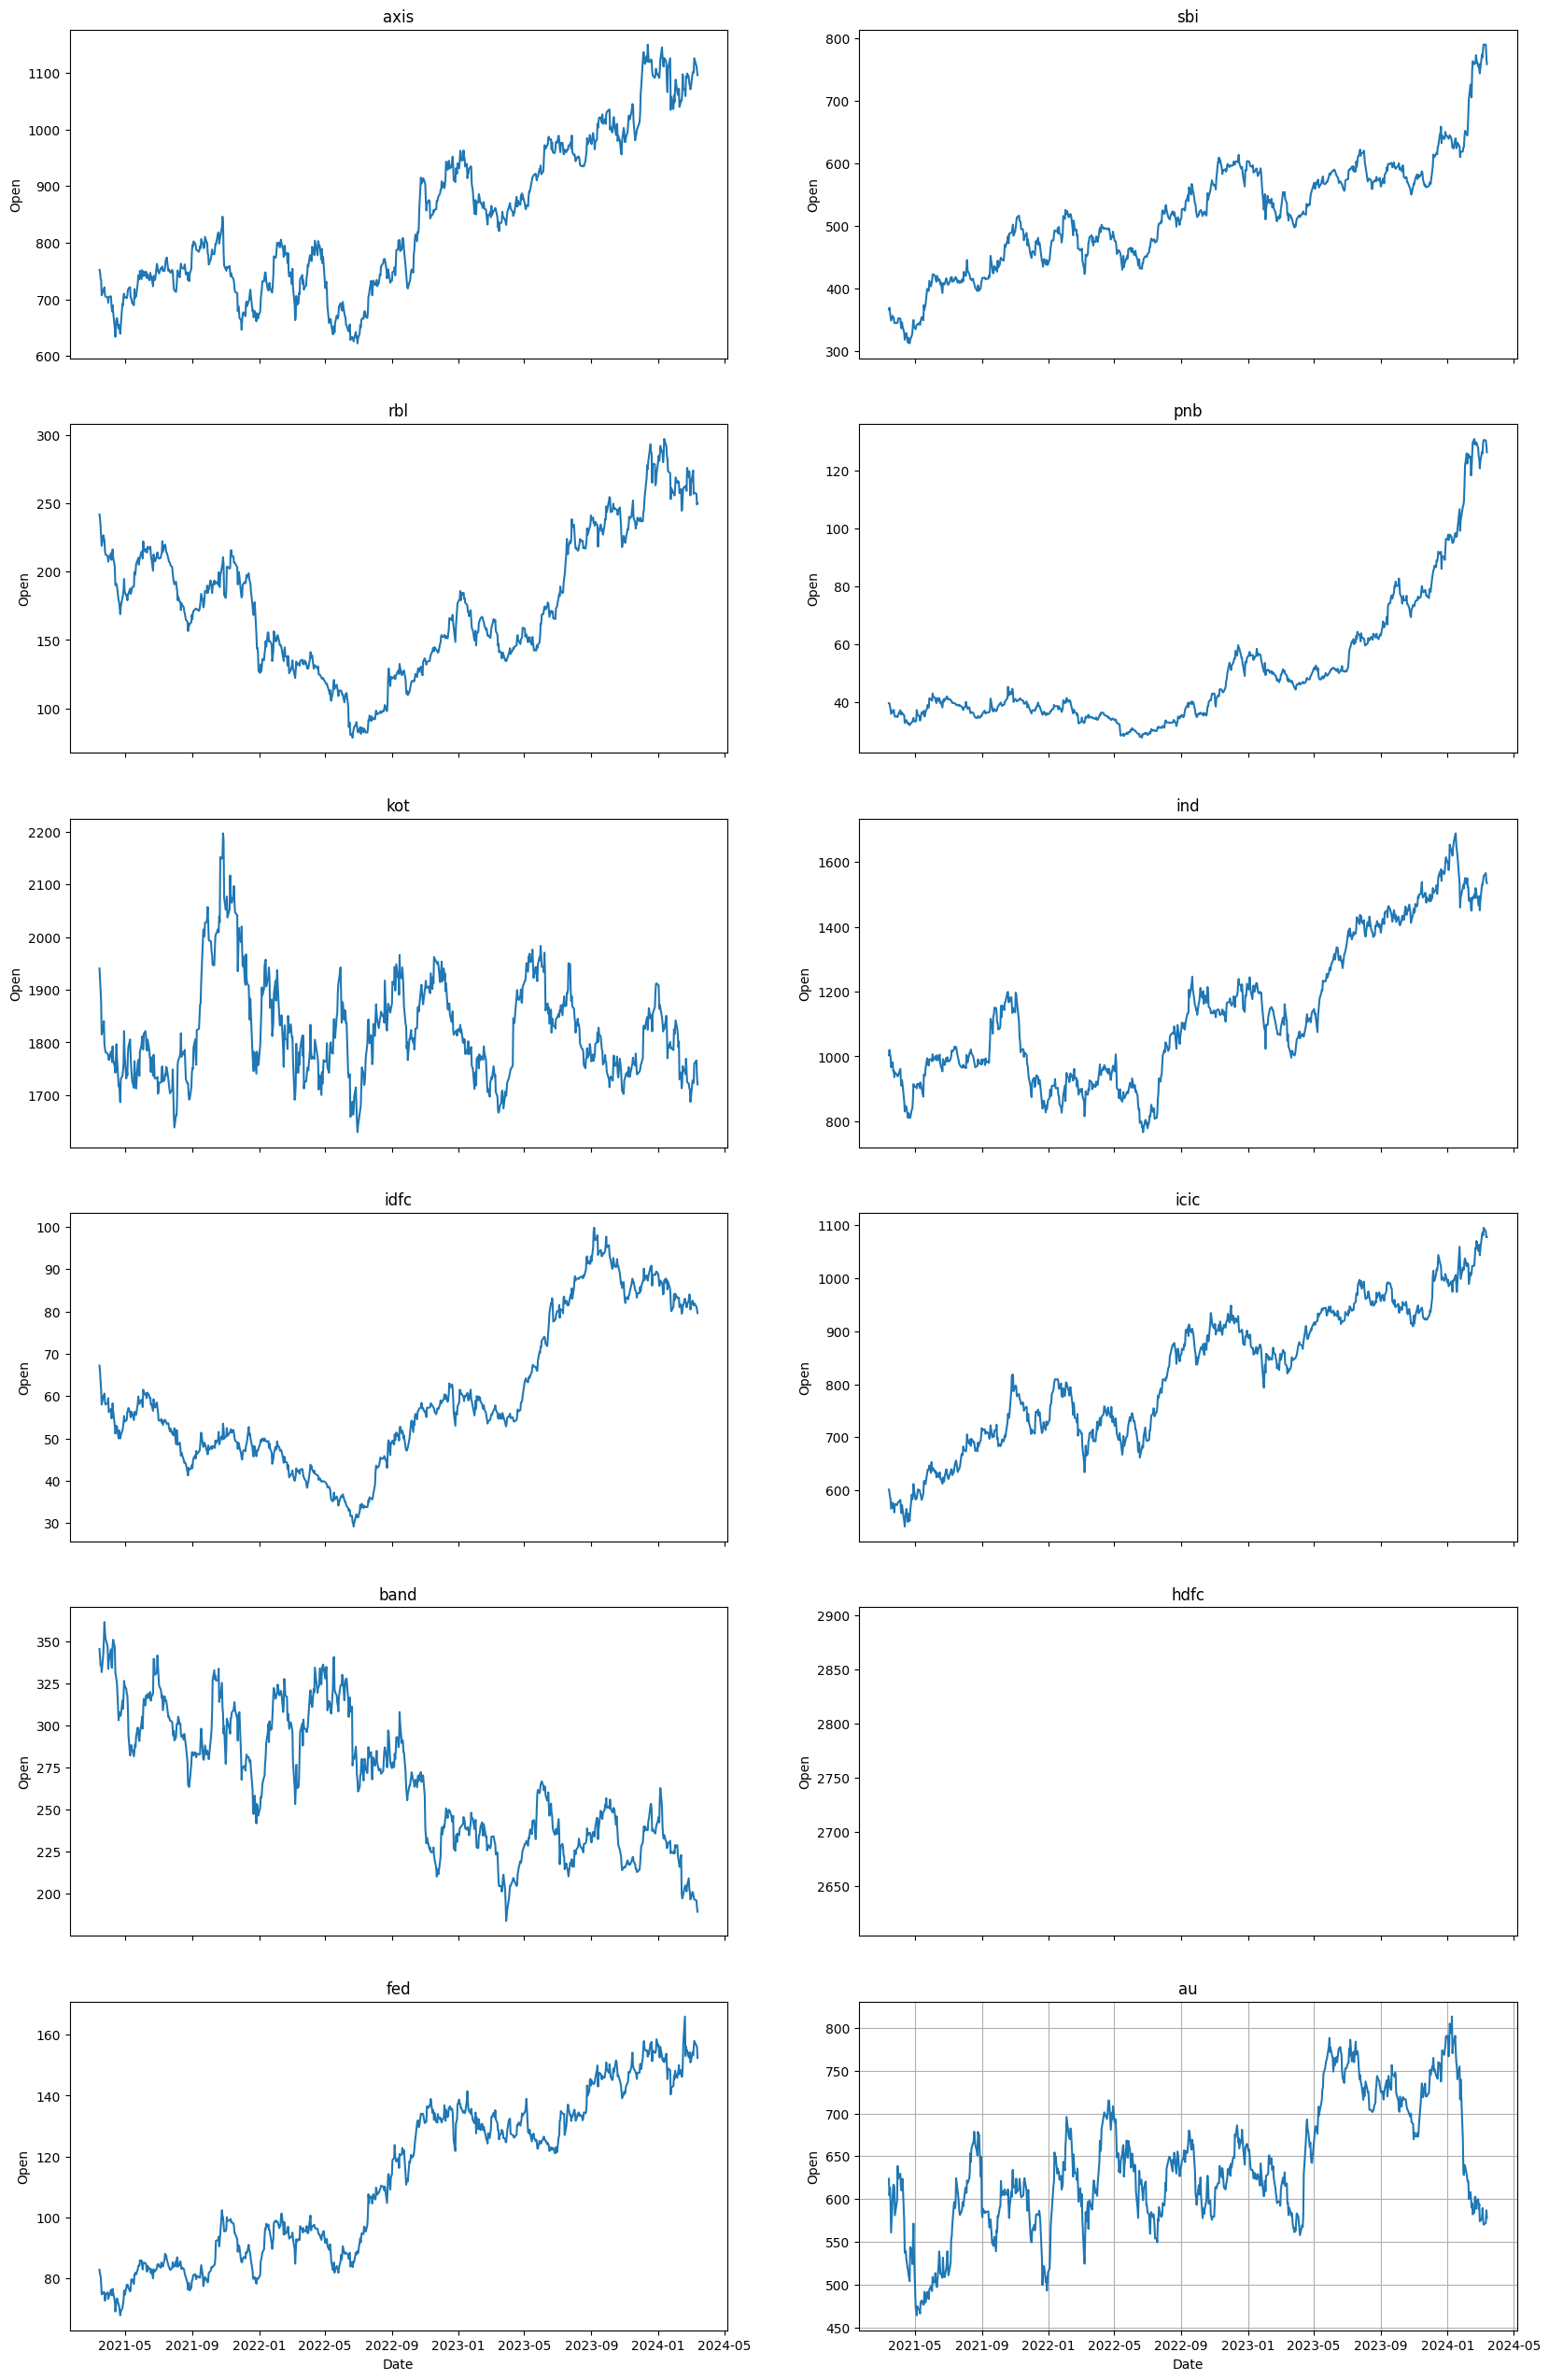

In [ ]:
fig, axes = plt.subplots(6, 2, sharex=True, figsize=(20,32))
plt.grid(True)
sns.lineplot(ax=axes[0, 0], data=df_axis, x='Date', y='Open')
axes[0,0].set_title('axis')
sns.lineplot(ax=axes[0, 1], data=df_sbi, x='Date', y='Open')
axes[0,1].set_title('sbi')
sns.lineplot(ax=axes[1, 0], data=df_rbl, x='Date', y='Open')
axes[1,0].set_title('rbl')
sns.lineplot(ax=axes[1, 1], data=df_pnb, x='Date', y='Open')
axes[1,1].set_title('pnb')
sns.lineplot(ax=axes[2, 0], data=df_kot, x='Date', y='Open')
axes[2,0].set_title('kot')
sns.lineplot(ax=axes[2, 1], data=df_ind, x='Date', y='Open')
axes[2,1].set_title('ind')
sns.lineplot(ax=axes[3, 0], data=df_idfc, x='Date', y='Open')
axes[3,0].set_title('idfc')
sns.lineplot(ax=axes[3, 1], data=df_icic, x='Date', y='Open')
axes[3,1].set_title('icic')
sns.lineplot(ax=axes[4, 0], data=df_band, x='Date', y='Open')
axes[4,0].set_title('band')
sns.lineplot(ax=axes[4, 1], data=df_hdfc, x='Date', y='Open')
axes[4,1].set_title('hdfc')
sns.lineplot(ax=axes[5, 0], data=df_fed, x='Date', y='Open')
axes[5,0].set_title('fed')
sns.lineplot(ax=axes[5,1], data=df_au, x='Date', y='Open')
axes[5,1].set_title('au')

In [ ]:
print(df.shape)
date_train=pd.to_datetime(df['Date'])
date_train

(739, 8)


0     2021-03-15 00:00:00+05:30
1     2021-03-16 00:00:00+05:30
2     2021-03-17 00:00:00+05:30
3     2021-03-18 00:00:00+05:30
4     2021-03-19 00:00:00+05:30
                 ...           
734   2024-03-06 00:00:00+05:30
735   2024-03-07 00:00:00+05:30
736   2024-03-11 00:00:00+05:30
737   2024-03-12 00:00:00+05:30
738   2024-03-13 00:00:00+05:30
Name: Date, Length: 739, dtype: datetime64[ns, Asia/Kolkata]

In [ ]:
Scale=StandardScaler()
def data_prep(df, lookback, future, Scale):
    date_train=pd.to_datetime(df['Date'])
    df_train=df[['Open','High','Low','Close','Volume','Dividends','Stock Splits']]
    df_train=df_train.astype(float)

    df_train_scaled=Scale.fit_transform(df_train)

    X, y =[],[]
    for i in range(lookback, len(df_train_scaled)-future+1):
        X.append(df_train_scaled[i-lookback:i, 0:df_train.shape[1]])
        y.append(df_train_scaled[i+future-1:i+future, 0])

    return np.array(X), np.array(y), df_train, date_train
Lstm_x, Lstm_y, df_train, date_train = data_prep(df, 30, 1, Scale)

In [ ]:
def Lstm_fallback(X,y):
    model = Sequential()

    model.add(LSTM(64, activation='relu',input_shape=(X.shape[1], X.shape[2]),  return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='relu'))

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
    model.compile(
            loss='mse',
            optimizer=opt,
        )

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X, y, epochs=100, verbose=1, callbacks=[es], validation_split=0.1, batch_size=16)
    return model

In [ ]:
def Lstm_model1(X, y):
    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    regressor.fit(X, y, epochs = 100, validation_split=0.1, batch_size = 64, verbose=1, callbacks=[es])
    return regressor

In [ ]:
def Lstm_model2(X,y):
    model=Sequential()

    model.add(LSTM(20,return_sequences=True,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    #model.add(LSTM(15,return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    adam = optimizers.Adam(0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X, y,validation_split=0.2,epochs=100,batch_size=64,verbose=1, callbacks=[es])
    return model

In [ ]:
def predict_open(model,date_train,Lstm_x,df_train, future, Scale):
    forecasting_dates=pd.date_range(list(date_train)[-1], periods=future, freq='1d').tolist()
    predicted=model.predict(Lstm_x[-future:])
    predicted1=np.repeat(predicted, df_train.shape[1], axis=-1)
    predicted_descaled=Scale.inverse_transform(predicted1)[:,0]
    return predicted_descaled,forecasting_dates

def output_prep(forecasting_dates,predicted_descaled):
    dates=[]
    for i in forecasting_dates:
      dates.append(i.date())
    df_final=pd.DataFrame(columns=['Date','Open'])
    df_final['Date']=pd.to_datetime(dates)
    df_final['Open']=predicted_descaled
    return df_final

In [ ]:
def results(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model1(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=30
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,future, Scale)
    results=output_prep(forecasting_dates,predicted_descaled)
    print(results.head())
    plt.show()
    fig = px.area(results, x="Date", y="Open", title=x)
    fig.update_yaxes(range=[results.Open.min()-10, results.Open.max()+10])
    fig.show()

In [ ]:
def results1(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model2(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=30
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,future, Scale)
    results=output_prep(forecasting_dates,predicted_descaled)
    print(results.head())
    plt.show()
    fig = px.area(results, x="Date", y="Open", title=x)
    fig.update_yaxes(range=[results.Open.min()-10, results.Open.max()+10])
    fig.show()

Epoch 1/100
10/10 [==============================] - 12s 469ms/step - loss: 0.2849 - val_loss: 0.1585
Epoch 2/100
10/10 [==============================] - 1s 80ms/step - loss: 0.1199 - val_loss: 0.3955
Epoch 3/100
10/10 [==============================] - 1s 98ms/step - loss: 0.1056 - val_loss: 0.2664
Epoch 4/100
10/10 [==============================] - 1s 91ms/step - loss: 0.0864 - val_loss: 0.2461
Epoch 5/100
10/10 [==============================] - 1s 98ms/step - loss: 0.0791 - val_loss: 0.1507
Epoch 6/100
10/10 [==============================] - 0s 44ms/step - loss: 0.0737 - val_loss: 0.2075
Epoch 7/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0728 - val_loss: 0.2117
Epoch 8/100
10/10 [==============================] - 0s 43ms/step - loss: 0.0725 - val_loss: 0.2138
Epoch 9/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0648 - val_loss: 0.2232
Epoch 10/100
10/10 [==============================] - 0s 44ms/step - loss: 0.0647 - val_loss: 0.22

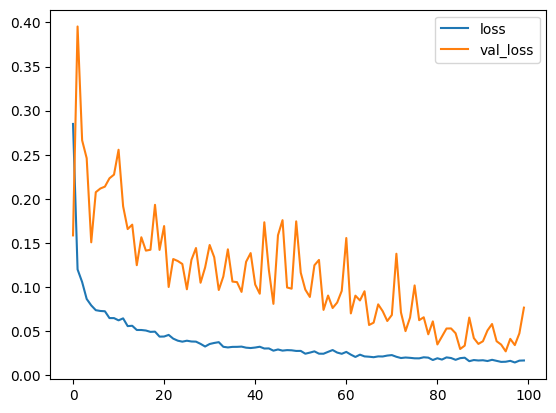

In [ ]:
results(df, 30, 1, Scale, 'NSEBANK')

Epoch 1/100
9/9 [==============================] - 3s 88ms/step - loss: 1.0713 - val_loss: 2.1038
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.5741 - val_loss: 1.7569
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 0.3122 - val_loss: 1.5787
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2066 - val_loss: 1.5069
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1596 - val_loss: 1.4820
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1502 - val_loss: 1.4534
Epoch 7/100
9/9 [==============================] - 0s 17ms/step - loss: 0.1387 - val_loss: 1.3758
Epoch 8/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1301 - val_loss: 1.3873
Epoch 9/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1219 - val_loss: 1.2887
Epoch 10/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0963 - val_loss: 1.2536
Epoch 11/100
9/9 [=

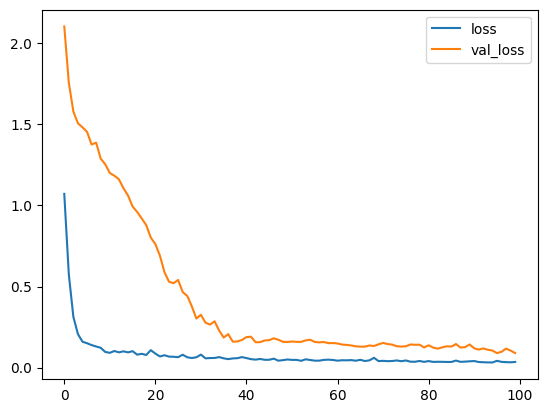

In [ ]:
results1(df, 30, 1, Scale, 'NSEBANK')

Epoch 1/100
9/9 [==============================] - 4s 88ms/step - loss: 1.1253 - val_loss: 2.5123
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.4981 - val_loss: 2.1305
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.2698 - val_loss: 1.9055
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2279 - val_loss: 1.8345
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1999 - val_loss: 1.8799
Epoch 6/100
9/9 [==============================] - 0s 18ms/step - loss: 0.1990 - val_loss: 1.8938
Epoch 7/100
9/9 [==============================] - 0s 17ms/step - loss: 0.1850 - val_loss: 1.8469
Epoch 8/100
9/9 [==============================] - 0s 17ms/step - loss: 0.1617 - val_loss: 1.7940
Epoch 9/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1604 - val_loss: 1.7262
Epoch 10/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1336 - val_loss: 1.6931
Epoch 11/100
9/9 [=

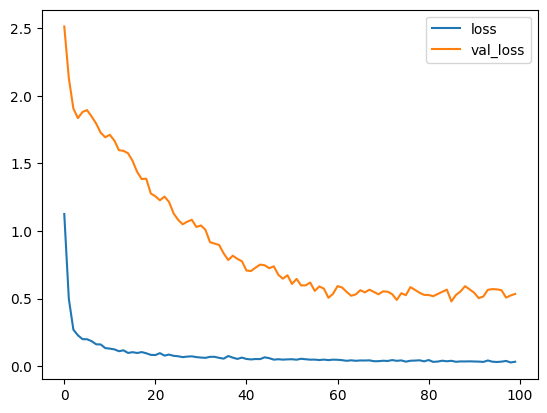

Epoch 1/100
9/9 [==============================] - 4s 89ms/step - loss: 0.9988 - val_loss: 1.9864
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.4238 - val_loss: 2.1001
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.2782 - val_loss: 2.1857
Epoch 4/100
9/9 [==============================] - 0s 29ms/step - loss: 0.2160 - val_loss: 2.1772
Epoch 5/100
9/9 [==============================] - 0s 26ms/step - loss: 0.2246 - val_loss: 2.1134
Epoch 6/100
9/9 [==============================] - 0s 30ms/step - loss: 0.1788 - val_loss: 2.1278
Epoch 7/100
9/9 [==============================] - 0s 30ms/step - loss: 0.1593 - val_loss: 2.1460
Epoch 8/100
9/9 [==============================] - 0s 22ms/step - loss: 0.1734 - val_loss: 2.0937
Epoch 9/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1395 - val_loss: 2.0786
Epoch 10/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1411 - val_loss: 1.9972
Epoch 11/100
9/9 [=

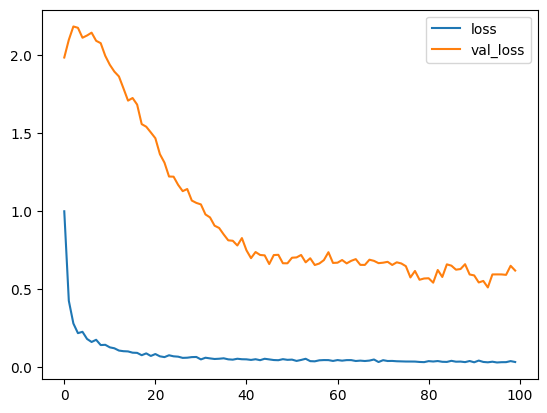

Epoch 1/100
9/9 [==============================] - 4s 90ms/step - loss: 0.4731 - val_loss: 1.8631
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2530 - val_loss: 1.9393
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2152 - val_loss: 1.9763
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 0.1708 - val_loss: 1.9332
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1427 - val_loss: 1.8941
Epoch 6/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1173 - val_loss: 1.8933
Epoch 7/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1018 - val_loss: 1.8695
Epoch 8/100
9/9 [==============================] - 0s 21ms/step - loss: 0.1124 - val_loss: 1.8364
Epoch 9/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0983 - val_loss: 1.8229
Epoch 10/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0822 - val_loss: 1.8195
Epoch 11/100
9/9 [=

1/1 [==============================] - 1s 567ms/step
        Date        Open
0 2024-03-13  222.671997
1 2024-03-14  222.743073
2 2024-03-15  223.055191
3 2024-03-16  223.066315
4 2024-03-17  223.054886


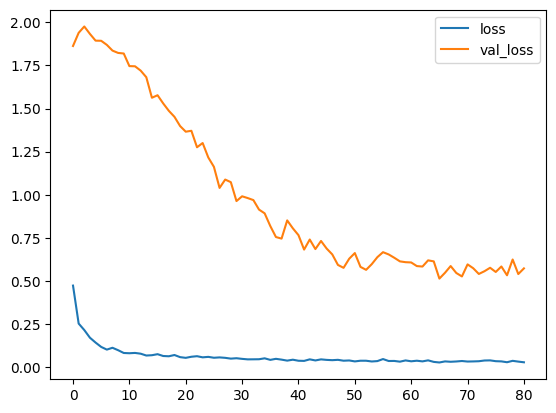

Epoch 1/100
9/9 [==============================] - 4s 102ms/step - loss: 0.3304 - val_loss: 3.5816
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2240 - val_loss: 3.6435
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1707 - val_loss: 3.5995
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1293 - val_loss: 3.7222
Epoch 5/100
9/9 [==============================] - 0s 25ms/step - loss: 0.1252 - val_loss: 3.9449
Epoch 6/100
9/9 [==============================] - 0s 29ms/step - loss: 0.1010 - val_loss: 3.9329
Epoch 7/100
9/9 [==============================] - 0s 30ms/step - loss: 0.0919 - val_loss: 3.8322
Epoch 8/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0768 - val_loss: 3.8141
Epoch 9/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0711 - val_loss: 3.7761
Epoch 10/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0741 - val_loss: 3.6888
Epoch 11/100
9/9 [

1/1 [==============================] - 1s 545ms/step
        Date       Open
0 2024-03-13  61.374256
1 2024-03-14  61.239677
2 2024-03-15  61.074890
3 2024-03-16  60.911983
4 2024-03-17  60.991558


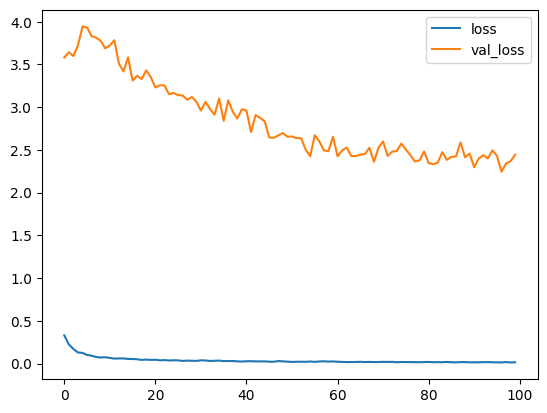

Epoch 1/100
9/9 [==============================] - 4s 95ms/step - loss: 1.1278 - val_loss: 0.4493
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.6559 - val_loss: 0.4259
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.4567 - val_loss: 0.3850
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 0.4305 - val_loss: 0.3526
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 0.3439 - val_loss: 0.3253
Epoch 6/100
9/9 [==============================] - 0s 22ms/step - loss: 0.2983 - val_loss: 0.3086
Epoch 7/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2715 - val_loss: 0.2999
Epoch 8/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2837 - val_loss: 0.2876
Epoch 9/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2774 - val_loss: 0.2786
Epoch 10/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2757 - val_loss: 0.2849
Epoch 11/100
9/9 [=

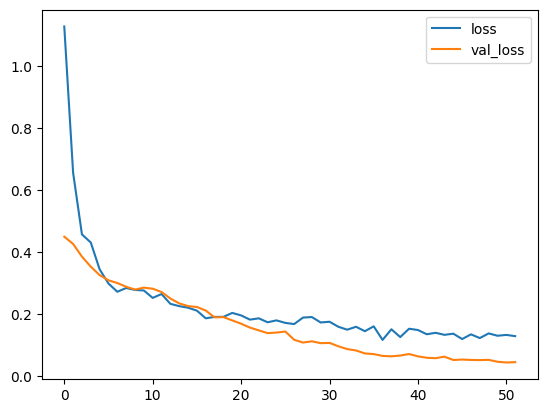

Epoch 1/100
9/9 [==============================] - 4s 94ms/step - loss: 0.6475 - val_loss: 2.4416
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.3484 - val_loss: 2.5558
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2474 - val_loss: 2.8115
Epoch 4/100
9/9 [==============================] - 0s 21ms/step - loss: 0.2274 - val_loss: 2.9292
Epoch 5/100
9/9 [==============================] - 0s 22ms/step - loss: 0.1939 - val_loss: 2.9138
Epoch 6/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1589 - val_loss: 2.8797
Epoch 7/100
9/9 [==============================] - 0s 18ms/step - loss: 0.1519 - val_loss: 2.9026
Epoch 8/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1372 - val_loss: 2.8688
Epoch 9/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1283 - val_loss: 2.8517
Epoch 10/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1093 - val_loss: 2.8222
Epoch 11/100
9/9 [=

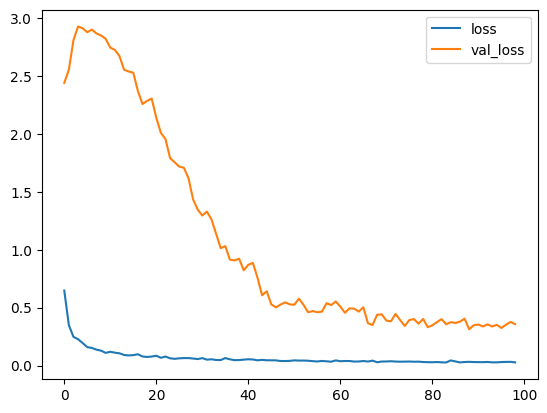

Epoch 1/100
9/9 [==============================] - 4s 97ms/step - loss: 0.9332 - val_loss: 2.0310
Epoch 2/100
9/9 [==============================] - 0s 20ms/step - loss: 0.4529 - val_loss: 2.1081
Epoch 3/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2928 - val_loss: 2.2328
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1854 - val_loss: 2.3051
Epoch 5/100
9/9 [==============================] - 0s 21ms/step - loss: 0.1788 - val_loss: 2.3039
Epoch 6/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1683 - val_loss: 2.2596
Epoch 7/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1575 - val_loss: 2.2455
Epoch 8/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1257 - val_loss: 2.2059
Epoch 9/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1348 - val_loss: 2.1664
Epoch 10/100
9/9 [==============================] - 0s 22ms/step - loss: 0.1156 - val_loss: 2.1548
Epoch 11/100
9/9 [=

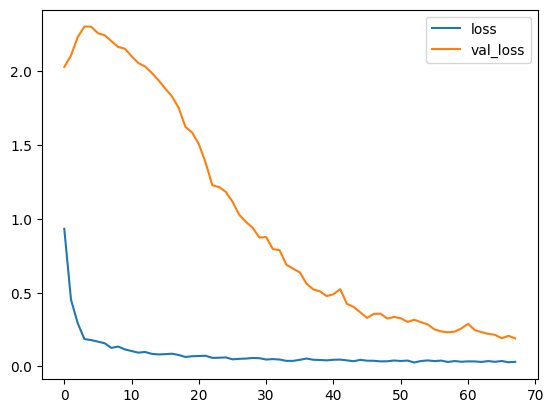

Epoch 1/100
9/9 [==============================] - 4s 93ms/step - loss: 0.3007 - val_loss: 1.2404
Epoch 2/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2057 - val_loss: 1.2417
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.1394 - val_loss: 1.2187
Epoch 4/100
9/9 [==============================] - 0s 21ms/step - loss: 0.1378 - val_loss: 1.1885
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0977 - val_loss: 1.1137
Epoch 6/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1056 - val_loss: 1.0565
Epoch 7/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0884 - val_loss: 1.0346
Epoch 8/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0950 - val_loss: 0.9654
Epoch 9/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0823 - val_loss: 0.9161
Epoch 10/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0821 - val_loss: 0.8887
Epoch 11/100
9/9 [=

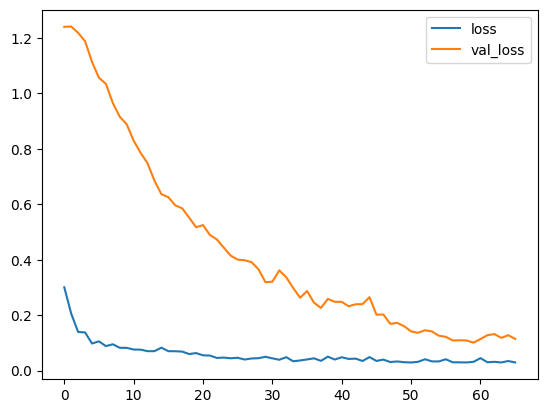

Epoch 1/100
9/9 [==============================] - 4s 92ms/step - loss: 0.7372 - val_loss: 0.9434
Epoch 2/100
9/9 [==============================] - 0s 22ms/step - loss: 0.4027 - val_loss: 0.9393
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.3286 - val_loss: 0.9438
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2316 - val_loss: 0.9031
Epoch 5/100
9/9 [==============================] - 0s 22ms/step - loss: 0.2180 - val_loss: 0.8583
Epoch 6/100
9/9 [==============================] - 0s 20ms/step - loss: 0.2139 - val_loss: 0.8208
Epoch 7/100
9/9 [==============================] - 0s 21ms/step - loss: 0.1641 - val_loss: 0.8121
Epoch 8/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1571 - val_loss: 0.7664
Epoch 9/100
9/9 [==============================] - 0s 20ms/step - loss: 0.1594 - val_loss: 0.7255
Epoch 10/100
9/9 [==============================] - 0s 21ms/step - loss: 0.1621 - val_loss: 0.7137
Epoch 11/100
9/9 [=

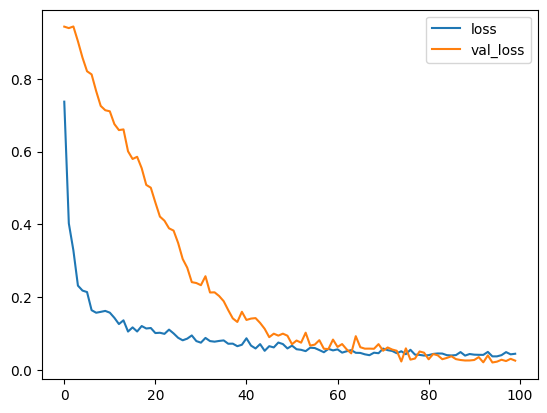

IndexError: tuple index out of range

In [ ]:
d={'AXIS':df_axis, 'SBI':df_sbi, 'RBL': df_rbl ,'PNB': df_pnb ,'KOTAK': df_kot,
   'INDUSIND':df_ind, 'IDFC': df_idfc, 'ICIC': df_icic , 'BANDHAN': df_band, 'HDFC': df_hdfc, 'FEDERAL': df_fed,
   'AU FIN':df_au}

for x in d.keys():
    results1(d[x], 30, 1, Scale, x)
